In [446]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time

import seaborn as sns

In [525]:
df = pd.read_csv('Index Rent Smart.csv',parse_dates=['date','last_major_renovation_date'],index_col=0)

/Users/bhavanian/myenvs/housing/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (57,68,70) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [526]:
df.shape

(127232, 123)

In [527]:
df['complaint_tuple'] = list(zip(df.violation_type, df.description))

In [528]:
df.complaint_tuple.nunique()

175

In [529]:
df['street_full'] = [' '.join(s) for s in list(zip(df.st_name,df.st_name_suf))]

In [530]:
# df.to_csv('Index Rent Smart_v2.csv')

In [242]:
df['property_type']

0               Residential 3-family
1               Residential 3-family
2               Residential 3-family
3               Residential 3-family
4               Residential 3-family
                     ...            
127227          Residential 3-family
127228    Mixed Use (Res. and Comm.)
127229          Residential 2-family
127230          Residential 3-family
127231          Residential 1-family
Name: property_type, Length: 127232, dtype: object

In [243]:
df['ptype']

0         105
1         105
2         105
3         105
4         105
         ... 
127227    105
127228     13
127229    104
127230    105
127231    101
Name: ptype, Length: 127232, dtype: int64

#### What best predicts severity of complaints for an apartment?

In [244]:
df['street_full'] = [' '.join(s) for s in list(zip(df.st_name,df.st_name_suf))]

In [246]:
loc_vars = ['zip_code','neighborhood','parcel','latitude','longitude',
 'street_full']

In [371]:
df['zip_code'] = df['zip_code'].astype(str)

In [372]:
df['parcel'] = df['parcel'].astype(str)

In [373]:
old_vars = [
    'year built',
'land_sf',
'gross_area',
'living_area',
'sqft',
'num_floors',
'num_bldgs',
'units_res',
'ct_perc_disability',
 'ct_perc_children_under_5',
 'ct_perc_over_65',
 'ct_perc_low_to_no_income',
 'ct_perc_limited_english_proficiency',
 'ct_perc_poc',
 'ct_perc_med_illness',
'ct_perc_income_200000_or_more']

In [293]:
df_select = df[['date','address','Index'] + old_vars + loc_vars]

In [294]:
df_select.dtypes

date                                   datetime64[ns]
address                                        object
Index                                           int64
year built                                    float64
land_sf                                       float64
gross_area                                    float64
living_area                                   float64
sqft                                          float64
num_floors                                    float64
num_bldgs                                       int64
units_res                                     float64
ct_perc_disability                            float64
ct_perc_children_under_5                      float64
ct_perc_over_65                               float64
ct_perc_low_to_no_income                      float64
ct_perc_limited_english_proficiency           float64
ct_perc_poc                                   float64
ct_perc_med_illness                           float64
ct_perc_income_200000_or_mor

In [295]:
cat_vars = ['zip_code','neighborhood','street_full','parcel']

In [296]:
df_byaddress = df_select.groupby('address').mean()

In [297]:
df_byaddress = df_byaddress.rename(columns={'Index':'Severity'})

In [298]:
df_byaddress[cat_vars] = df_select.groupby('address')[cat_vars].agg(pd.Series.mode)

In [299]:
index_sum = df_select.groupby('address')['Index'].sum()

In [300]:
df_byaddress['Index_Sum'] = index_sum 

In [301]:
oldest_complaint = df_select.groupby('address')['date'].min()

In [302]:
newest_complaint = df.groupby('address')['date'].max()

In [303]:
df_byaddress['Timeframe'] = (newest_complaint - oldest_complaint)

In [304]:
df_byaddress['Frequency_of_Complaints'] = df_byaddress['Index_Sum'] / df_byaddress['Timeframe'].dt.days

In [305]:
df_byaddress

,Severity,year built,land_sf,gross_area,living_area,sqft,num_floors,num_bldgs,units_res,ct_perc_disability,...,ct_perc_income_200000_or_more,latitude,longitude,zip_code,neighborhood,street_full,parcel,Index_Sum,Timeframe,Frequency_of_Complaints
address,,,,,,,,,,,,,,,,,,,,,
"1 Abbotsford St, 02121",5.000000,1900.0,3577.0,5528.0,3109.0,3109.0,2.0,1.0,2.0,20.738363,...,1.061571,42.31465,-71.09318,2121,Dorchester,ABBOTSFORD ST,1203002000,10,413 days 00:00:00,0.024213
"1 Acorn St, 02108",8.000000,1829.0,822.0,2939.0,2300.0,2300.0,4.0,1.0,2.0,4.102075,...,26.284658,42.35761,-71.06857,2108,Boston,ACORN ST,501530000,40,650 days 01:51:00,0.061538
"1 Adams St, 02129",5.000000,1857.0,1056.0,4093.0,3843.0,3843.0,4.0,1.0,1.0,6.503690,...,25.625000,42.37484,-71.06004,2129,Charlestown,ADAMS ST,203373000,5,0 days 00:00:00,inf
"1 Akron Pl, 02119",5.000000,1890.0,1654.0,1911.0,1200.0,1200.0,2.0,1.0,1.0,18.717277,...,2.694236,42.32572,-71.08477,2119,Roxbury,AKRON PL,1201336000,5,0 days 00:00:00,inf
"1 Aldie St, 02134",5.000000,1890.0,4014.0,4060.0,2623.0,2623.0,2.5,1.0,2.0,7.853982,...,3.987847,42.35913,-71.13683,2134,Allston,ALDIE ST,2201264000,35,1386 days 00:00:00,0.025253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"994 River St, 02136",5.222222,1925.0,5002.0,3842.0,2356.0,3842.0,2.0,1.0,NaN,15.402695,...,2.724043,42.26072,-71.11465,2136,Hyde Park,RIVER ST,1804421000,47,1400 days 00:00:00,0.033571
"995 Centre St, 02130",5.000000,1984.0,13357.0,4596.0,3042.0,3042.0,1.0,1.0,1.0,9.574468,...,28.631139,42.30670,-71.12455,2130,Jamaica Plain,CENTRE ST,1902502010,5,0 days 00:00:00,inf
"996 South St, 02131",4.666667,1907.0,5068.0,4894.0,3116.0,3116.0,2.5,1.0,2.0,9.572582,...,11.955056,42.28745,-71.13991,2131,Roslindale,SOUTH ST,2005587000,14,707 days 00:00:00,0.019802


/var/folders/gn/2v3k2j5j1rl3jtww424x4zc40000gn/T/ipykernel_53868/3950479863.py:1: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df_byaddress.Timeframe.astype(int).loc[df_byaddress.Timeframe.astype(int) > 0].hist()


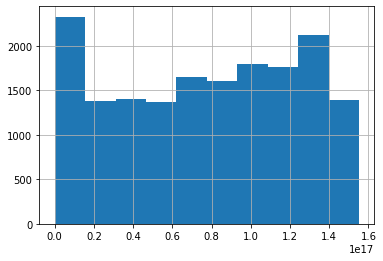

In [306]:
df_byaddress.Timeframe.astype(int).loc[df_byaddress.Timeframe.astype(int) > 0].hist()
plt.show()

In [307]:
df_byaddress = df_byaddress.drop(columns=['Timeframe'])

In [308]:
df_byaddress.to_csv('byaddress_addlocvars.csv')

In [309]:
df['building_typology']

0          Multi-Family (3 units)
1          Multi-Family (3 units)
2          Multi-Family (3 units)
3          Multi-Family (3 units)
4          Multi-Family (3 units)
                   ...           
127227     Multi-Family (3 units)
127228    Residential (Mixed-Use)
127229     Multi-Family (2 units)
127230     Multi-Family (3 units)
127231              Single-Family
Name: building_typology, Length: 127232, dtype: object

In [312]:
df['building_subtypology']

0          Multi-Family (3 units), Pre-1915
1          Multi-Family (3 units), Pre-1915
2          Multi-Family (3 units), Pre-1915
3          Multi-Family (3 units), Pre-1915
4          Multi-Family (3 units), Pre-1915
                        ...                
127227    Multi-Family (3 units), 1915-1949
127228    Residential (Mixed-Use), Pre-1915
127229     Multi-Family (2 units), Pre-1915
127230     Multi-Family (3 units), Pre-1915
127231              Single-Family, Pre-1915
Name: building_subtypology, Length: 127232, dtype: object

In [319]:
df['building_subtypology'].nunique()

44

In [311]:
df['property_type']

0               Residential 3-family
1               Residential 3-family
2               Residential 3-family
3               Residential 3-family
4               Residential 3-family
                     ...            
127227          Residential 3-family
127228    Mixed Use (Res. and Comm.)
127229          Residential 2-family
127230          Residential 3-family
127231          Residential 1-family
Name: property_type, Length: 127232, dtype: object

In [318]:
df['property_type'].nunique()

7

In [313]:
df['ptype']

0         105
1         105
2         105
3         105
4         105
         ... 
127227    105
127228     13
127229    104
127230    105
127231    101
Name: ptype, Length: 127232, dtype: int64

In [317]:
df['ptype'].nunique()

44

In [314]:
df['use_class']

0                     Residential
1                     Residential
2                     Residential
3                     Residential
4                     Residential
                   ...           
127227                Residential
127228    Residential (Mixed-Use)
127229                Residential
127230                Residential
127231                Residential
Name: use_class, Length: 127232, dtype: object

In [315]:
df['use_class'].nunique()

6

In [320]:
df['sqft_class']

0         < 25,000 sqft
1         < 25,000 sqft
2         < 25,000 sqft
3         < 25,000 sqft
4         < 25,000 sqft
              ...      
127227    < 25,000 sqft
127228    < 25,000 sqft
127229    < 25,000 sqft
127230    < 25,000 sqft
127231    < 25,000 sqft
Name: sqft_class, Length: 127232, dtype: object

In [321]:
df['sqft_class'].nunique()

5

In [322]:
df['gross_area']

0         7107.0
1         7107.0
2         7107.0
3         7107.0
4         7107.0
           ...  
127227    6222.0
127228    4072.0
127229    2382.0
127230    3784.0
127231    1984.0
Name: gross_area, Length: 127232, dtype: float64

In [323]:
df['living_area']

0         4758.0
1         4758.0
2         4758.0
3         4758.0
4         4758.0
           ...  
127227    3833.0
127228    3054.0
127229    1580.0
127230    2838.0
127231    1232.0
Name: living_area, Length: 127232, dtype: float64

In [324]:
df['structure_class']

0         R
1         R
2         R
3         R
4         R
         ..
127227    R
127228    D
127229    R
127230    R
127231    R
Name: structure_class, Length: 127232, dtype: object

In [325]:
df['structure_class'].nunique()

6

In [326]:
df['bldg_styl']

0          DK
1          DK
2          DK
3          DK
4          DK
         ... 
127227     CV
127228    NaN
127229     TF
127230     DK
127231     SD
Name: bldg_styl, Length: 127232, dtype: object

In [327]:
df['ext_fin']

0           M
1           M
2           M
3           M
4           M
         ... 
127227      W
127228    NaN
127229      P
127230      M
127231      M
Name: ext_fin, Length: 127232, dtype: object

In [329]:
df['insulation_type'].count()

331

In [385]:
df['foundation_type'].count()

2324

In [387]:
df['ext_cond_list'].count()

98693

In [390]:
list(df['ext_cond_list'])[-100:]

['A',
 'A',
 'G',
 'A',
 'A',
 'A',
 'A',
 'A',
 'G',
 'G',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'G',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'G',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'G',
 'A',
 'A',
 'G',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'G',
 'G',
 'A',
 'G',
 'G',
 'A',
 'G',
 'G',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'G',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'G',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'F',
 'A',
 nan,
 'A',
 'A',
 'A',
 'A',
 'F',
 nan,
 'A',
 'A',
 'A']

In [331]:
df['flood'].value_counts()
# 	Description
# 75	Whether the property falls within the 1% annual flood zone, assuming 36 inches of sea level rise
# 76	Whether the property falls within the stormwater flood zone

f    113298
t     13934
Name: flood, dtype: int64

In [401]:
df['ac']

0           C
1           C
2           C
3           C
4           C
         ... 
127227      N
127228    NaN
127229      N
127230      N
127231      N
Name: ac, Length: 127232, dtype: object

In [402]:
df['heat_typ']

0           F
1           F
2           F
3           F
4           F
         ... 
127227      W
127228    NaN
127229      W
127230      W
127231      W
Name: heat_typ, Length: 127232, dtype: object

In [531]:
building_vars = [
    # 'date',
 # 'violation_type',
 # 'description',
 # 'Description Category',
 # 'Index',
 # 'address',
 # 'neighborhood',
 # 'zip_code',
 # 'parcel',
 # 'owner',
 # 'year built',
 # 'year remodeled',
 # 'property_type',
 # 'latitude',
 # 'longitude',
 # 'st_num',
 # 'st_name',
 # 'st_name_suf',
 # 'zipcode_str',
 # 'id',
 # 'pid_long',
 # 'cm_id',
 # 'building_typology',
 'building_subtypology',
 # 'use_class',
 'sqft_class',
 'year_built_class',
 # 'unit_num',
 # 'zipcode',
 # 'yr_built',
 # 'land_sf',
 # 'gross_area',
 'living_area',
 # 'sqft',
 # 'num_floors',
 # 'num_bldgs',
 # 'units_res',
 # 'units_com',
 # 'units_mixed',
 # 'ptype',
 # 'ptype_list',
 # 'lu',
 # 'lu_list',
 # 'assessor_category',
 # 'assessor_description',
 # 'own_occ',
 # 'own_occ_list',
 # 'owner_list',
 # 'structure_class',
 # 'structure_class_list',
 # 'bldg_styl',
 # 'bldg_styl_list',
 # 'r_roof_typ',
 'ext_fin',
 # 'ext_fin_list',
 'ext_cond_list',
 # 'insulation_type',
 # 'foundation_type',
 'heat_typ',
 # 'heat_typ_list',
 # 'heating_system_fuel',
 'ac',
 # 'ac_list',
 # 'ac_system_type',
 # 'hot_water_system_fuel',
 # 'electric_panel_info',
 # 'has_pv',
 # 'existing_ashp',
 # 'existing_gshp',
 # 'existing_shw',
 # 'historic_district',
 # 'landmark',
 'flood',
 'stormwater',
 'last_major_renovation_date',
 # 'total_site_energy_kbtu',
 # 'perc_electricity',
 # 'perc_gas',
 # 'perc_steam',
 # 'onsite_renewable_kwh',
 # 'census_tract_number',
 # 'ct_pop_disability',
 # 'ct_pop_children_under_5',
 # 'ct_pop_over_65',
 # 'ct_pop_low_to_no_income',
 # 'ct_pop_limited_english_proficiency',
 # 'ct_pop_poc',
 # 'ct_pop_med_illness',
 # 'ct_perc_disability',
 # 'ct_perc_children_under_5',
 # 'ct_perc_over_65',
 # 'ct_perc_low_to_no_income',
 # 'ct_perc_limited_english_proficiency',
 # 'ct_perc_poc',
 # 'ct_perc_med_illness',
 # 'ct_hh_income_200000_or_more',
 # 'ct_perc_income_200000_or_more',
 # 'cashp_only',
 # 'cashp_and_elec_upgrade',
 # 'cashp_outdoor',
 # 'dashp_only',
 # 'dashp_and_elec_upgrade',
 # 'dashp_outdoor',
 # 'gshp_only',
 # 'gshp_and_elec_upgrade',
 # 'vrf_only',
 # 'vrf_and_elec_upgrade',
 # 'awhp_only',
 # 'awhp_and_elec_upgrade',
 # 'hp_recommendation_count',
 # 'insulate_attic',
 # 'insulate_attic_converted',
 # 'ext_roof_insulation',
 # 'insulate_exposed_ducts',
 # 'insulate_exposed_pipes',
 # 'interior_wall_insulation_blow_in',
 # 'exterior_wall_insulation_at_replacement',
 # 'exterior_wall_insulation',
 # 'interior_wall_insulation_board',
 # 'insulate_spandrel',
 # 'asbestos',
 # 'seal_elevator_vent_shafts',
 # 'env_recommendation_count',
 # 'complaint_tuple',
 # 'street_full'
]

In [532]:
other_vars = ['date','address','Index'] + ['complaint_tuple',
              # 'owner',
               'census_tract_number',
                '
             ]

In [533]:
demo_vars =  [
'ct_pop_disability',
 'ct_pop_children_under_5',
 'ct_pop_over_65',
 'ct_pop_low_to_no_income',
 'ct_pop_limited_english_proficiency',
 'ct_pop_poc',
 'ct_pop_med_illness',
 'ct_perc_disability',
 'ct_perc_children_under_5',
 'ct_perc_over_65',
 'ct_perc_low_to_no_income',
 'ct_perc_limited_english_proficiency',
 'ct_perc_poc',
 'ct_perc_med_illness',
 'ct_hh_income_200000_or_more',
 'ct_perc_income_200000_or_more']

In [689]:
df[ other_vars + building_vars + demo_vars ].columns

Index(['date', 'address', 'Index', 'complaint_tuple', 'census_tract_number',
       'building_subtypology', 'sqft_class', 'year_built_class', 'living_area',
       'ext_fin', 'ext_cond_list', 'heat_typ', 'ac', 'flood', 'stormwater',
       'last_major_renovation_date', 'ct_pop_disability',
       'ct_pop_children_under_5', 'ct_pop_over_65', 'ct_pop_low_to_no_income',
       'ct_pop_limited_english_proficiency', 'ct_pop_poc',
       'ct_pop_med_illness', 'ct_perc_disability', 'ct_perc_children_under_5',
       'ct_perc_over_65', 'ct_perc_low_to_no_income',
       'ct_perc_limited_english_proficiency', 'ct_perc_poc',
       'ct_perc_med_illness', 'ct_hh_income_200000_or_more',
       'ct_perc_income_200000_or_more'],
      dtype='object')

In [535]:
df.shape

(127232, 125)

In [536]:
df_select = df[ other_vars + building_vars + demo_vars ]

In [537]:
df_select.shape

(127232, 32)

In [538]:
df_select.count()

date                                   127232
address                                127232
Index                                  127232
complaint_tuple                        127232
census_tract_number                    127213
building_subtypology                   122380
sqft_class                             126612
year_built_class                       126269
living_area                            127162
ext_fin                                 98693
ext_cond_list                           98693
heat_typ                               100490
ac                                      98693
flood                                  127232
stormwater                             127232
last_major_renovation_date              50483
ct_pop_disability                      127213
ct_pop_children_under_5                127213
ct_pop_over_65                         127213
ct_pop_low_to_no_income                127213
ct_pop_limited_english_proficiency     127213
ct_pop_poc                        

In [539]:
df_select.dtypes

date                                   datetime64[ns]
address                                        object
Index                                           int64
complaint_tuple                                object
census_tract_number                           float64
building_subtypology                           object
sqft_class                                     object
year_built_class                               object
living_area                                   float64
ext_fin                                        object
ext_cond_list                                  object
heat_typ                                       object
ac                                             object
flood                                          object
stormwater                                     object
last_major_renovation_date             datetime64[ns]
ct_pop_disability                             float64
ct_pop_children_under_5                       float64
ct_pop_over_65              

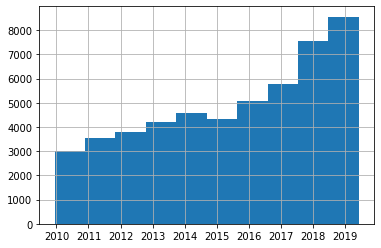

In [540]:
df_select.last_major_renovation_date.hist()
plt.show()

In [541]:
df_select = df_select.drop(columns=['last_major_renovation_date'])

In [542]:
df_select.columns

Index(['date', 'address', 'Index', 'complaint_tuple', 'census_tract_number',
       'building_subtypology', 'sqft_class', 'year_built_class', 'living_area',
       'ext_fin', 'ext_cond_list', 'heat_typ', 'ac', 'flood', 'stormwater',
       'ct_pop_disability', 'ct_pop_children_under_5', 'ct_pop_over_65',
       'ct_pop_low_to_no_income', 'ct_pop_limited_english_proficiency',
       'ct_pop_poc', 'ct_pop_med_illness', 'ct_perc_disability',
       'ct_perc_children_under_5', 'ct_perc_over_65',
       'ct_perc_low_to_no_income', 'ct_perc_limited_english_proficiency',
       'ct_perc_poc', 'ct_perc_med_illness', 'ct_hh_income_200000_or_more',
       'ct_perc_income_200000_or_more'],
      dtype='object')

In [543]:
df_select['sqft_class'].unique()

array(['< 25,000 sqft', '25,000-34,999 sqft', nan, '50,000-99,999 sqft',
       '35,000-49,999 sqft', '>= 100,000 sqft'], dtype=object)

In [544]:
df_select['sqft_class_code'] = 0

In [545]:
df_select.loc[df_select.sqft_class == '< 25,000 sqft','sqft_class_code'] = 0
df_select.loc[df_select.sqft_class == '25,000-34,999 sqft','sqft_class_code'] = 1
df_select.loc[df_select.sqft_class == '35,000-49,999 sqft','sqft_class_code'] = 2
df_select.loc[df_select.sqft_class == '50,000-99,999 sqft','sqft_class_code'] = 3
df_select.loc[df_select.sqft_class == '>= 100,000 sqft','sqft_class_code'] = 4

In [546]:
df_select.sqft_class_code.unique()

array([0, 1, 3, 2, 4])

In [549]:
df_select = df_select.drop(columns='sqft_class')

In [547]:
# 	Use Code	Use Code Category
# 349	Exterior Condition Codes	
# 350	Code	Description
# 351	A	Average
# 352	E	Excellent
# 353	F	Fair
# 354	G	Good
# 355	P	Poor

In [548]:
df_select['ext_cond_list'].unique()

array(['G', 'A', nan, 'P', 'F', 'E'], dtype=object)

In [550]:
df_select['ext_cond_list_code'] = 0

In [551]:
df_select.loc[df_select.ext_cond_list == 'P','ext_cond_list_code'] = 0
df_select.loc[df_select.ext_cond_list == 'G','ext_cond_list_code'] = 1
df_select.loc[df_select.ext_cond_list == 'F','ext_cond_list_code'] = 2
df_select.loc[df_select.ext_cond_list == 'E','ext_cond_list_code'] = 3
df_select.loc[df_select.ext_cond_list == 'A','ext_cond_list_code'] = 4

In [552]:
df_select['ext_cond_list_code'].unique()

array([1, 4, 0, 2, 3])

In [553]:
df_select = df_select.drop(columns='ext_cond_list')

In [554]:
df_select['year_built_class'].unique()

array(['Pre-1915', '1915-1949', '1980-present', '1950-1979', nan],
      dtype=object)

In [555]:
df_select['year_built_class_code'] = 0

In [556]:
df_select.loc[df_select.year_built_class == 'Pre-1915', 'year_built_class_code'] = 0
df_select.loc[df_select.year_built_class == '1915-1949', 'year_built_class_code'] = 1
df_select.loc[df_select.year_built_class == '1950-1979', 'year_built_class_code'] = 2
df_select.loc[df_select.year_built_class == '1980-present', 'year_built_class_code'] = 3

In [563]:
df_select = df_select.drop(columns='year_built_class')

In [468]:
# cat_vars = [
#     # 'census_tract_number',
#        'building_subtypology', 'sqft_class',  'ext_fin',
#        'ext_cond_list', 'heat_typ', 'ac', 'flood', 'stormwater','year_built_class']

In [557]:
one_hot_vars = [
    # 'census_tract_number',
       'building_subtypology',  'ext_fin',
        'heat_typ', 'ac', 'flood', 'stormwater']

In [558]:
one_hot_enc = pd.get_dummies(df_select[one_hot_vars])

In [559]:
df_select = df_select.drop(columns=one_hot_vars)

In [560]:
df_select = df_select.merge(one_hot_enc,left_index=True,right_index=True)

In [561]:
df_select.shape

(127232, 97)

In [564]:
list(df_select)

['date',
 'address',
 'Index',
 'complaint_tuple',
 'census_tract_number',
 'living_area',
 'ct_pop_disability',
 'ct_pop_children_under_5',
 'ct_pop_over_65',
 'ct_pop_low_to_no_income',
 'ct_pop_limited_english_proficiency',
 'ct_pop_poc',
 'ct_pop_med_illness',
 'ct_perc_disability',
 'ct_perc_children_under_5',
 'ct_perc_over_65',
 'ct_perc_low_to_no_income',
 'ct_perc_limited_english_proficiency',
 'ct_perc_poc',
 'ct_perc_med_illness',
 'ct_hh_income_200000_or_more',
 'ct_perc_income_200000_or_more',
 'sqft_class_code',
 'ext_cond_list_code',
 'year_built_class_code',
 'building_subtypology_Garage, 1915-1949',
 'building_subtypology_Multi-Family (2 units), 1915-1949',
 'building_subtypology_Multi-Family (2 units), 1950-1979',
 'building_subtypology_Multi-Family (2 units), 1980-present',
 'building_subtypology_Multi-Family (2 units), Pre-1915',
 'building_subtypology_Multi-Family (3 units), 1915-1949',
 'building_subtypology_Multi-Family (3 units), 1950-1979',
 'building_subtypolo

In [475]:
list(df_select.dtypes)

[dtype('<M8[ns]'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('<M8[ns]'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uin

In [565]:
list(df_select.count())

[127232,
 127232,
 127232,
 127232,
 127213,
 127162,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127213,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232,
 127232]

In [566]:
df_select = df_select.replace([- np.inf,np.inf],np.nan).dropna()

In [567]:
df_select.to_csv('Index Rent Smart_v2_1.csv')

In [579]:
df_select = pd.read_csv('Index Rent Smart_v2_1.csv',index_col=0,parse_dates=['date'])

In [581]:
df_select.columns

Index(['date', 'address', 'Index', 'complaint_tuple', 'census_tract_number',
       'living_area', 'ct_pop_disability', 'ct_pop_children_under_5',
       'ct_pop_over_65', 'ct_pop_low_to_no_income',
       'ct_pop_limited_english_proficiency', 'ct_pop_poc',
       'ct_pop_med_illness', 'ct_perc_disability', 'ct_perc_children_under_5',
       'ct_perc_over_65', 'ct_perc_low_to_no_income',
       'ct_perc_limited_english_proficiency', 'ct_perc_poc',
       'ct_perc_med_illness', 'ct_hh_income_200000_or_more',
       'ct_perc_income_200000_or_more', 'sqft_class_code',
       'ext_cond_list_code', 'year_built_class_code',
       'building_subtypology_Garage, 1915-1949',
       'building_subtypology_Multi-Family (2 units), 1915-1949',
       'building_subtypology_Multi-Family (2 units), 1950-1979',
       'building_subtypology_Multi-Family (2 units), 1980-present',
       'building_subtypology_Multi-Family (2 units), Pre-1915',
       'building_subtypology_Multi-Family (3 units), 1915-1949'

In [582]:
df_select = df_select.loc[:, (df_select != 0).any(axis=0)]

In [583]:
df_select.shape

(127143, 96)

In [585]:
df_select.sqft_class_code.unique()

array([0, 1, 3, 2, 4])

In [586]:
df_byaddress  = df_select.groupby('address').mean()

In [587]:
df_byaddress.columns

Index(['Index', 'census_tract_number', 'living_area', 'ct_pop_disability',
       'ct_pop_children_under_5', 'ct_pop_over_65', 'ct_pop_low_to_no_income',
       'ct_pop_limited_english_proficiency', 'ct_pop_poc',
       'ct_pop_med_illness', 'ct_perc_disability', 'ct_perc_children_under_5',
       'ct_perc_over_65', 'ct_perc_low_to_no_income',
       'ct_perc_limited_english_proficiency', 'ct_perc_poc',
       'ct_perc_med_illness', 'ct_hh_income_200000_or_more',
       'ct_perc_income_200000_or_more', 'sqft_class_code',
       'ext_cond_list_code', 'year_built_class_code',
       'building_subtypology_Garage, 1915-1949',
       'building_subtypology_Multi-Family (2 units), 1915-1949',
       'building_subtypology_Multi-Family (2 units), 1950-1979',
       'building_subtypology_Multi-Family (2 units), 1980-present',
       'building_subtypology_Multi-Family (2 units), Pre-1915',
       'building_subtypology_Multi-Family (3 units), 1915-1949',
       'building_subtypology_Multi-Family (

In [588]:
list(df_byaddress.iloc[0,:])

[5.0,
 25025081900.0,
 3109.0,
 646.0,
 704.0,
 312.0,
 1101.0,
 1413.0,
 3047.0,
 1160.74,
 20.73836276,
 22.60032103,
 10.01605136,
 35.34510433,
 45.3611557,
 97.81701445,
 37.26292135,
 15.0,
 1.061571125,
 0.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0]

In [589]:
df_byaddress.shape

(25537, 93)

In [590]:
df_byaddress.to_csv('byaddress_v2_1.csv')

In [591]:
df_byaddress = df_byaddress.rename(columns={'Index':'Severity'})

In [592]:
df_byaddress['Severity_class'] = 0

In [593]:
df_byaddress.loc[df_byaddress.Severity > 6,'Severity_class'] = 1

In [594]:
df_byaddress['Severity_class_v2'] = 0

In [595]:
df_byaddress.loc[df_byaddress.Severity > 7,'Severity_class_v2'] = 1

In [601]:
df_byaddress.columns

Index(['Severity', 'census_tract_number', 'living_area', 'ct_pop_disability',
       'ct_pop_children_under_5', 'ct_pop_over_65', 'ct_pop_low_to_no_income',
       'ct_pop_limited_english_proficiency', 'ct_pop_poc',
       'ct_pop_med_illness', 'ct_perc_disability', 'ct_perc_children_under_5',
       'ct_perc_over_65', 'ct_perc_low_to_no_income',
       'ct_perc_limited_english_proficiency', 'ct_perc_poc',
       'ct_perc_med_illness', 'ct_hh_income_200000_or_more',
       'ct_perc_income_200000_or_more', 'sqft_class_code',
       'ext_cond_list_code', 'year_built_class_code',
       'building_subtypology_Garage, 1915-1949',
       'building_subtypology_Multi-Family (2 units), 1915-1949',
       'building_subtypology_Multi-Family (2 units), 1950-1979',
       'building_subtypology_Multi-Family (2 units), 1980-present',
       'building_subtypology_Multi-Family (2 units), Pre-1915',
       'building_subtypology_Multi-Family (3 units), 1915-1949',
       'building_subtypology_Multi-Famil

In [602]:
df_byaddress_v2 = df_byaddress.drop(columns=['ct_pop_disability','ct_pop_children_under_5', 'ct_pop_over_65', 'ct_pop_low_to_no_income',
       'ct_pop_limited_english_proficiency', 'ct_pop_poc',
       'ct_pop_med_illness','ct_hh_income_200000_or_more'])

/var/folders/gn/2v3k2j5j1rl3jtww424x4zc40000gn/T/ipykernel_53868/2540791195.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(abs(corr), mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.color_palette("RdPu",20),


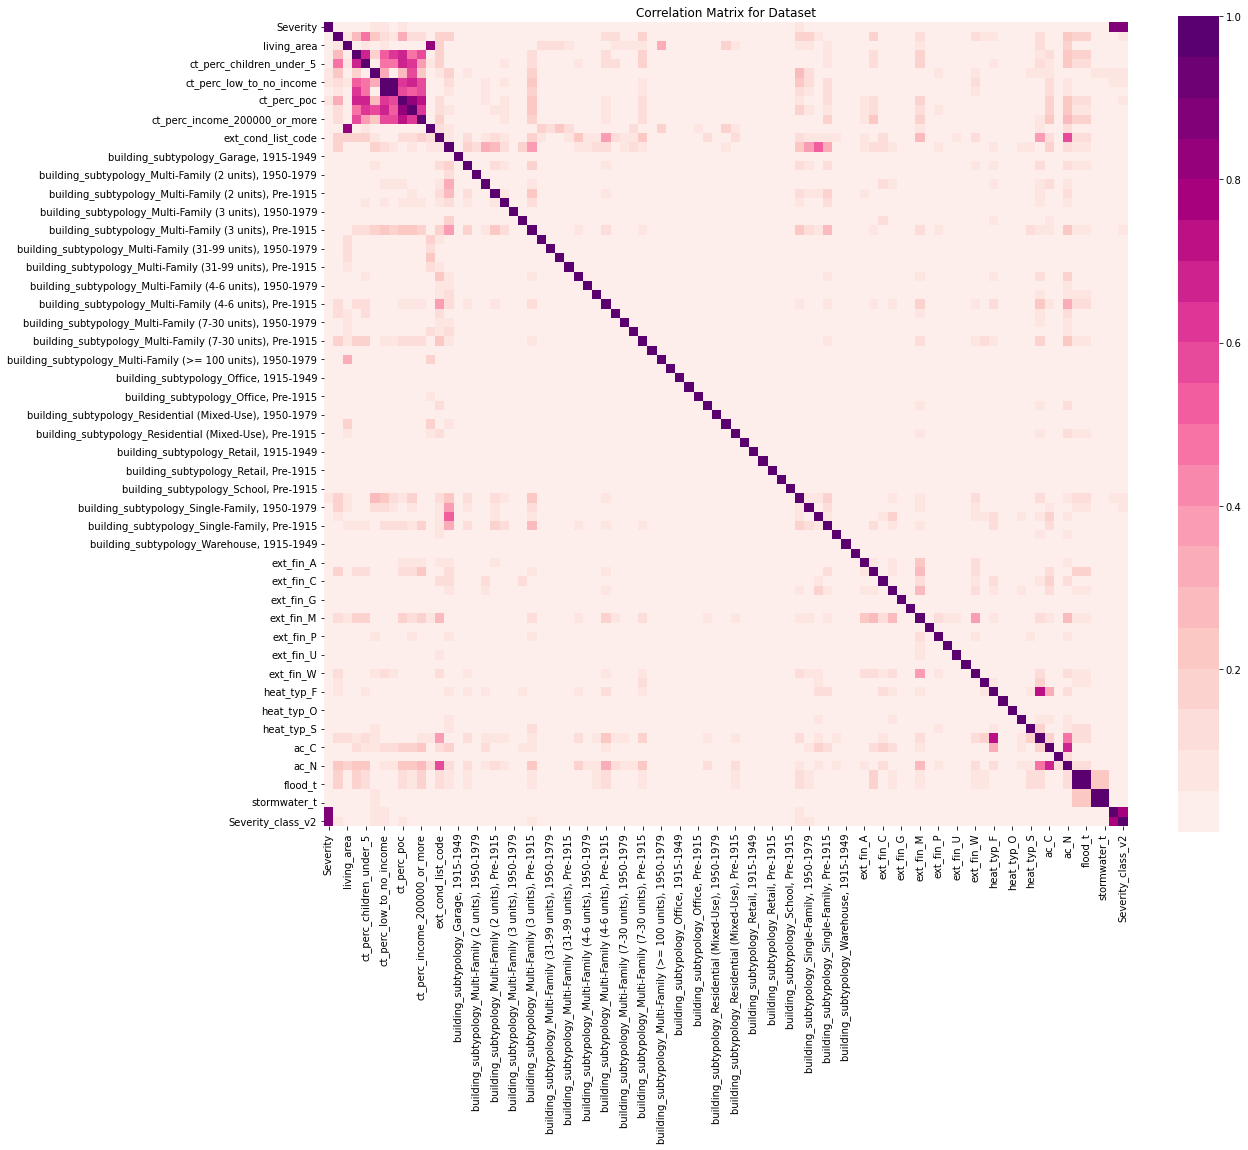

In [603]:
f, ax = plt.subplots(figsize=(18, 15))
corr = df_byaddress_v2.corr()
sns.heatmap(abs(corr), mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.color_palette("RdPu",20),
            square=True, ax=ax)
plt.title('Correlation Matrix for Dataset')
plt.show()

/var/folders/gn/2v3k2j5j1rl3jtww424x4zc40000gn/T/ipykernel_53868/1471470246.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(abs(corr), mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.color_palette("RdPu",20),


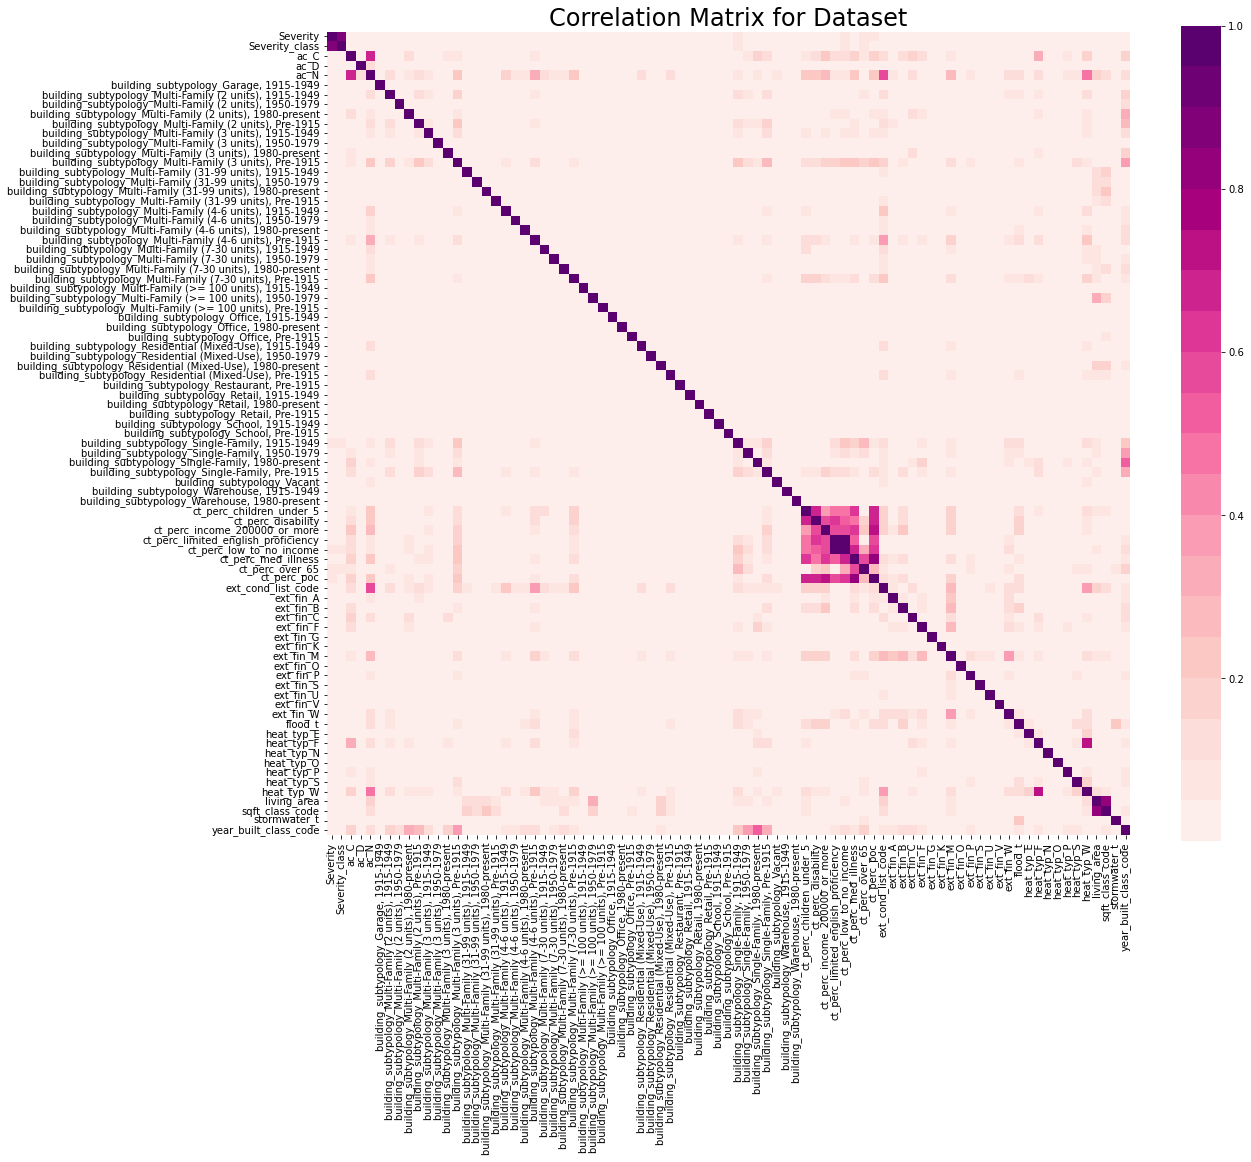

In [700]:
f, ax = plt.subplots(figsize=(18, 15))
corr = df_byaddress_v2.drop(columns=['census_tract_number','Severity_class_v2','flood_f','stormwater_f','poc_CT']).sort_index(axis=1).corr()
sns.heatmap(abs(corr), mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.color_palette("RdPu",20),
            square=True, xticklabels=1,yticklabels=1, ax=ax)
plt.title('Correlation Matrix for Dataset',fontsize=24)
plt.savefig('corr.png')
plt.show()

In [605]:
df_group1 = df_byaddress_v2.loc[df_byaddress_v2.Severity_class_v2 == 0].copy()

In [606]:
df_group2 = df_byaddress_v2.loc[df_byaddress_v2.Severity_class_v2 == 1].copy()

In [609]:
df_byaddress_v2.columns

Index(['Severity', 'census_tract_number', 'living_area', 'ct_perc_disability',
       'ct_perc_children_under_5', 'ct_perc_over_65',
       'ct_perc_low_to_no_income', 'ct_perc_limited_english_proficiency',
       'ct_perc_poc', 'ct_perc_med_illness', 'ct_perc_income_200000_or_more',
       'sqft_class_code', 'ext_cond_list_code', 'year_built_class_code',
       'building_subtypology_Garage, 1915-1949',
       'building_subtypology_Multi-Family (2 units), 1915-1949',
       'building_subtypology_Multi-Family (2 units), 1950-1979',
       'building_subtypology_Multi-Family (2 units), 1980-present',
       'building_subtypology_Multi-Family (2 units), Pre-1915',
       'building_subtypology_Multi-Family (3 units), 1915-1949',
       'building_subtypology_Multi-Family (3 units), 1950-1979',
       'building_subtypology_Multi-Family (3 units), 1980-present',
       'building_subtypology_Multi-Family (3 units), Pre-1915',
       'building_subtypology_Multi-Family (31-99 units), 1915-1949',


In [611]:
df_group1.mode()[['census_tract_number','sqft_class_code', 'ext_cond_list_code', 'year_built_class_code']]

,census_tract_number,sqft_class_code,ext_cond_list_code,year_built_class_code
0,2.502509e+10,0.0,4.0,0.0


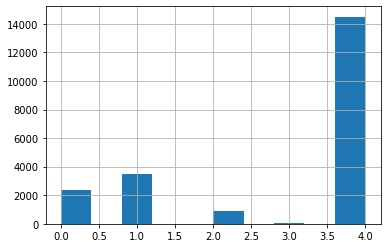

In [617]:
df_group1.ext_cond_list_code.hist()
plt.show()

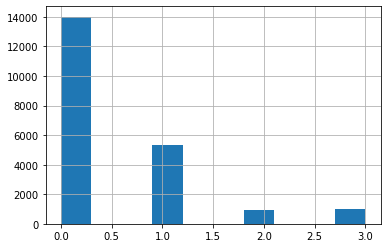

In [619]:
df_group1.year_built_class_code.hist()
plt.show()

In [614]:
df_group2.mode()[['census_tract_number','sqft_class_code', 'ext_cond_list_code', 'year_built_class_code']]

,census_tract_number,sqft_class_code,ext_cond_list_code,year_built_class_code
0,2.502513e+10,0.0,4.0,0.0
1,NaN,NaN,NaN,NaN


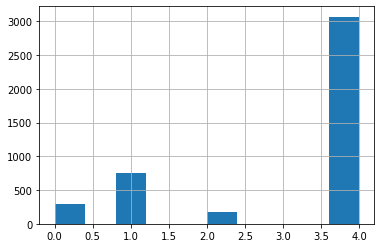

In [618]:
df_group2.ext_cond_list_code.hist()
plt.show()

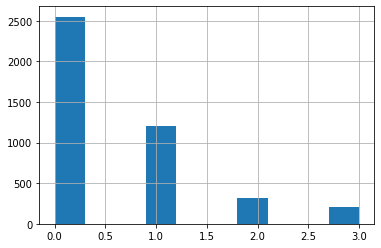

In [620]:
df_group2.year_built_class_code.hist()
plt.show()

In [633]:
one_hot_feats_1 = ['building_subtypology_Garage, 1915-1949',
       'building_subtypology_Multi-Family (2 units), 1915-1949',
       'building_subtypology_Multi-Family (2 units), 1950-1979',
       'building_subtypology_Multi-Family (2 units), 1980-present',
       'building_subtypology_Multi-Family (2 units), Pre-1915',
       'building_subtypology_Multi-Family (3 units), 1915-1949',
       'building_subtypology_Multi-Family (3 units), 1950-1979',
       'building_subtypology_Multi-Family (3 units), 1980-present',
       'building_subtypology_Multi-Family (3 units), Pre-1915',
       'building_subtypology_Multi-Family (31-99 units), 1915-1949',
       'building_subtypology_Multi-Family (31-99 units), 1950-1979',
       'building_subtypology_Multi-Family (31-99 units), 1980-present',
       'building_subtypology_Multi-Family (31-99 units), Pre-1915',
       'building_subtypology_Multi-Family (4-6 units), 1915-1949',
       'building_subtypology_Multi-Family (4-6 units), 1950-1979',
       'building_subtypology_Multi-Family (4-6 units), 1980-present',
       'building_subtypology_Multi-Family (4-6 units), Pre-1915',
       'building_subtypology_Multi-Family (7-30 units), 1915-1949',
       'building_subtypology_Multi-Family (7-30 units), 1950-1979',
       'building_subtypology_Multi-Family (7-30 units), 1980-present',
       'building_subtypology_Multi-Family (7-30 units), Pre-1915',
       'building_subtypology_Multi-Family (>= 100 units), 1915-1949',
       'building_subtypology_Multi-Family (>= 100 units), 1950-1979',
       'building_subtypology_Multi-Family (>= 100 units), Pre-1915',
       'building_subtypology_Office, 1915-1949',
       'building_subtypology_Office, 1980-present',
       'building_subtypology_Office, Pre-1915',
       'building_subtypology_Residential (Mixed-Use), 1915-1949',
       'building_subtypology_Residential (Mixed-Use), 1950-1979',
       'building_subtypology_Residential (Mixed-Use), 1980-present',
       'building_subtypology_Residential (Mixed-Use), Pre-1915',
       'building_subtypology_Restaurant, Pre-1915',
       'building_subtypology_Retail, 1915-1949',
       'building_subtypology_Retail, 1980-present',
       'building_subtypology_Retail, Pre-1915',
       'building_subtypology_School, 1915-1949',
       'building_subtypology_School, Pre-1915',
       'building_subtypology_Single-Family, 1915-1949',
       'building_subtypology_Single-Family, 1950-1979',
       'building_subtypology_Single-Family, 1980-present',
       'building_subtypology_Single-Family, Pre-1915',
       'building_subtypology_Vacant',
       'building_subtypology_Warehouse, 1915-1949',
       'building_subtypology_Warehouse, 1980-present']
one_hot_feats_2 = ['ext_fin_A',
       'ext_fin_B', 'ext_fin_C', 'ext_fin_F', 'ext_fin_G', 'ext_fin_K',
       'ext_fin_M', 'ext_fin_O', 'ext_fin_P', 'ext_fin_S', 'ext_fin_U',
       'ext_fin_V', 'ext_fin_W']
one_hot_feats_3 = ['heat_typ_E', 'heat_typ_F', 'heat_typ_N',
       'heat_typ_O', 'heat_typ_P', 'heat_typ_S', 'heat_typ_W']
one_hot_feats_4 = ['ac_C', 'ac_D',
       'ac_N']
one_hot_feats_5 = ['flood_f', 'flood_t', 'stormwater_f', 'stormwater_t']

<Figure size 720x720 with 0 Axes>

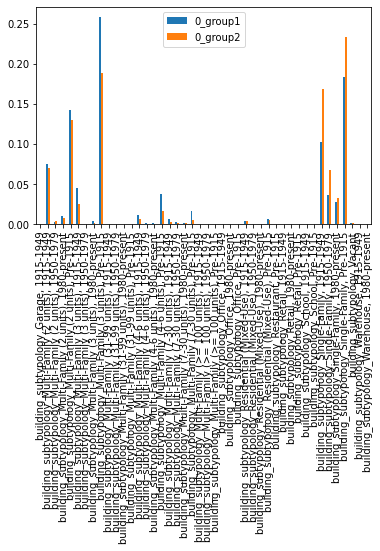

In [635]:
plt.figure(figsize=(10,10))
df_group1[one_hot_feats_1].mean().to_frame().merge(df_group2[one_hot_feats_1].mean().to_frame(),left_index=True,right_index=True,suffixes=('_group1','_group2')).plot.bar()
plt.show()

<Figure size 720x720 with 0 Axes>

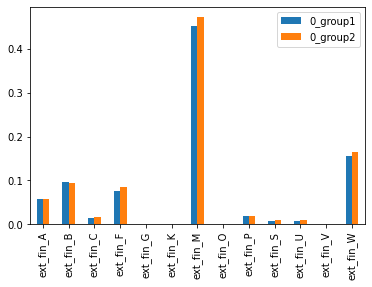

In [636]:
plt.figure(figsize=(10,10))
df_group1[one_hot_feats_2].mean().to_frame().merge(df_group2[one_hot_feats_2].mean().to_frame(),left_index=True,right_index=True,suffixes=('_group1','_group2')).plot.bar()
plt.show()

<Figure size 720x720 with 0 Axes>

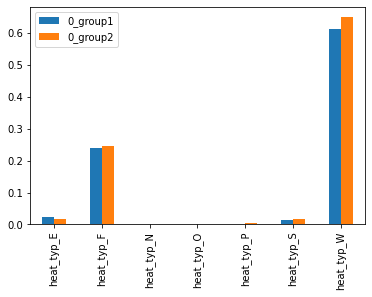

In [637]:
plt.figure(figsize=(10,10))
df_group1[one_hot_feats_3].mean().to_frame().merge(df_group2[one_hot_feats_3].mean().to_frame(),left_index=True,right_index=True,suffixes=('_group1','_group2')).plot.bar()
plt.show()

<Figure size 720x720 with 0 Axes>

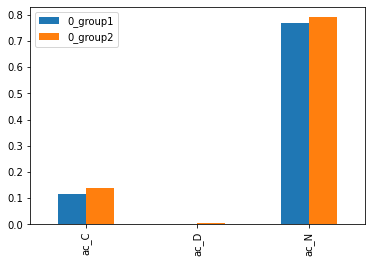

In [638]:
plt.figure(figsize=(10,10))
df_group1[one_hot_feats_4].mean().to_frame().merge(df_group2[one_hot_feats_4].mean().to_frame(),left_index=True,right_index=True,suffixes=('_group1','_group2')).plot.bar()
plt.show()

<Figure size 720x720 with 0 Axes>

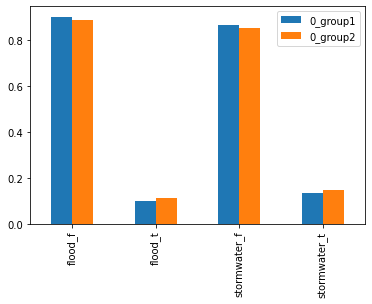

In [639]:
plt.figure(figsize=(10,10))
df_group1[one_hot_feats_5].mean().to_frame().merge(df_group2[one_hot_feats_5].mean().to_frame(),left_index=True,right_index=True,suffixes=('_group1','_group2')).plot.bar()
plt.show()

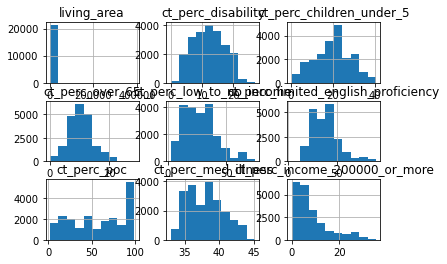

In [641]:
df_group1[['living_area', 'ct_perc_disability',
       'ct_perc_children_under_5', 'ct_perc_over_65',
       'ct_perc_low_to_no_income', 'ct_perc_limited_english_proficiency',
       'ct_perc_poc', 'ct_perc_med_illness', 'ct_perc_income_200000_or_more']].hist()
plt.show()

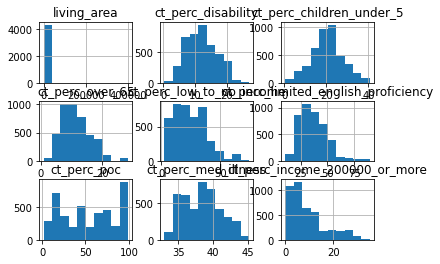

In [643]:
df_group2[['living_area', 'ct_perc_disability',
       'ct_perc_children_under_5', 'ct_perc_over_65',
       'ct_perc_low_to_no_income', 'ct_perc_limited_english_proficiency',
       'ct_perc_poc', 'ct_perc_med_illness', 'ct_perc_income_200000_or_more']].hist()
plt.show()

(0.0, 100.0)

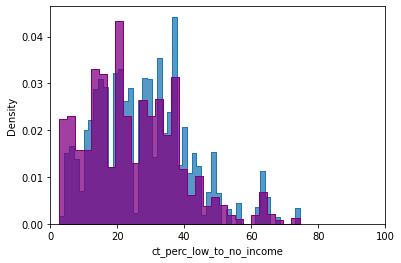

In [665]:
fig, ax = plt.subplots()
sns.histplot(df_group1.ct_perc_low_to_no_income, ax=ax, kde=False,stat='density',element='step')
sns.histplot(df_group2.ct_perc_low_to_no_income, ax=ax, kde=False,stat='density',element='step',color='purple')
ax.set_xlim([0, 100])

(0.0, 100.0)

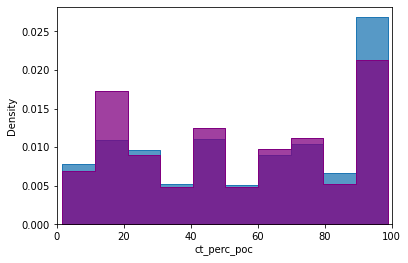

In [690]:
fig, ax = plt.subplots()
sns.histplot(df_group1.ct_perc_poc, bins=10,ax=ax, kde=False,stat='density',element='step')
sns.histplot(df_group2.ct_perc_poc, bins=10,ax=ax, kde=False,stat='density',element='step',color='purple')
ax.set_xlim([0, 100])

<AxesSubplot:xlabel='ct_perc_over_65', ylabel='Density'>

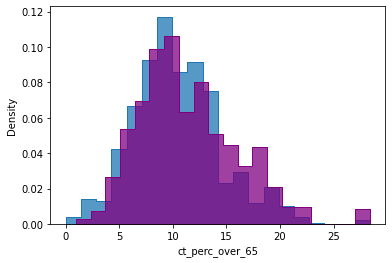

In [672]:
fig, ax = plt.subplots()
sns.histplot(df_group1.ct_perc_over_65, bins=20,ax=ax, kde=False,stat='density',element='step')
sns.histplot(df_group2.ct_perc_over_65, bins=20,ax=ax, kde=False,stat='density',element='step',color='purple')
# ax.set_xlim([0, 100])

<AxesSubplot:xlabel='ct_perc_income_200000_or_more', ylabel='Density'>

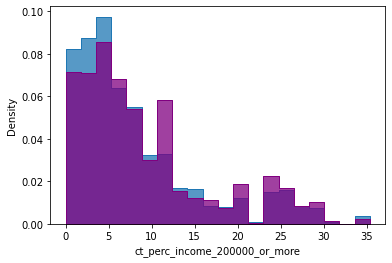

In [673]:
fig, ax = plt.subplots()
sns.histplot(df_group1.ct_perc_income_200000_or_more, bins=20,ax=ax, kde=False,stat='density',element='step')
sns.histplot(df_group2.ct_perc_income_200000_or_more, bins=20,ax=ax, kde=False,stat='density',element='step',color='purple')
# ax.set_xlim([0, 100])

<AxesSubplot:xlabel='ct_perc_limited_english_proficiency', ylabel='Density'>

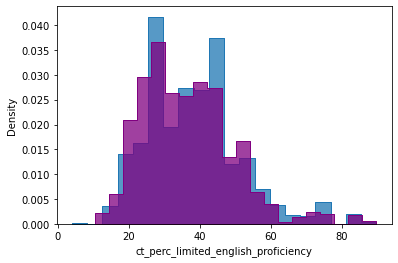

In [674]:
fig, ax = plt.subplots()
sns.histplot(df_group1.ct_perc_limited_english_proficiency, bins=20,ax=ax, kde=False,stat='density',element='step')
sns.histplot(df_group2.ct_perc_limited_english_proficiency, bins=20,ax=ax, kde=False,stat='density',element='step',color='purple')
# ax.set_xlim([0, 100])

In [686]:
df_byaddress_v2['poc_CT'] = 0
df_byaddress_v2.loc[df_byaddress_v2.ct_perc_poc >= 85,'poc_CT'] = 1

In [687]:
df_byaddress_v2['poc_CT'].corr(df_byaddress_v2['Severity'])

-0.05121202030612127

In [688]:
df_byaddress_v2.to_csv('byaddress_v2_2.csv')

In [676]:
df_byaddress.groupby('poc_CT')['Severity_class_v2'].mean()

poc_CT
0    0.181884
1    0.135046
Name: Severity_class_v2, dtype: float64

In [677]:
df_byaddress.groupby('poc_CT')['Severity'].mean()

poc_CT
0    5.694705
1    5.492176
Name: Severity, dtype: float64

<AxesSubplot:xlabel='Severity', ylabel='Density'>

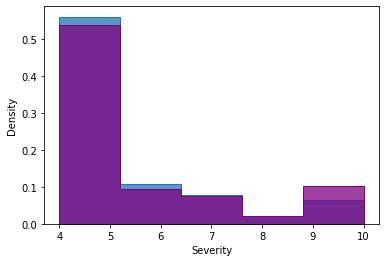

In [679]:
fig, ax = plt.subplots()
sns.histplot(df_byaddress.loc[df_byaddress.poc_CT == 1,'Severity'], bins=5,ax=ax, kde=False,stat='density',element='step')
sns.histplot(df_byaddress.loc[df_byaddress.poc_CT == 0,'Severity'], bins=5,ax=ax, kde=False,stat='density',element='step',color='purple')
# ax.set_xlim([0, 100])

In [513]:
group1_stats = df_group1.describe().iloc[1:3,2:-2].T

In [514]:
group2_stats = df_group2.describe().iloc[1:3,2:-2].T

In [515]:
group_stats = group1_stats.merge(group2_stats,left_index=True,right_index=True,suffixes=('_grp1','_grp2'))

In [520]:
group_stats = group_stats.drop(['ct_pop_disability','ct_pop_children_under_5', 'ct_pop_over_65', 'ct_pop_low_to_no_income',
       'ct_pop_limited_english_proficiency', 'ct_pop_poc',
       'ct_pop_med_illness','ct_hh_income_200000_or_more'])

In [521]:
group_stats

,mean_grp1,std_grp1,mean_grp2,std_grp2
year_built_class,0.431401,0.746694,0.497795,0.767705
living_area,2753.802622,1110.754674,2478.691871,1023.262229
ct_perc_disability,12.701629,4.974914,12.259987,4.753345
ct_perc_children_under_5,21.082780,8.275909,20.735363,7.291674
ct_perc_over_65,10.625952,3.995266,11.758956,4.770273
ct_perc_low_to_no_income,27.752123,14.025173,24.456037,14.147089
ct_perc_limited_english_proficiency,38.378075,13.267988,36.214994,12.639927
ct_perc_poc,60.686073,31.632596,53.716658,31.229686
ct_perc_med_illness,37.881353,2.618689,38.421505,2.717212
ct_perc_income_200000_or_more,8.137167,7.451466,9.481663,8.051485


In [149]:
setup_1 = df_byaddress.dropna()

In [150]:
setup_1.shape

(15848, 19)

In [151]:
X = setup_1.drop(columns=['Severity','Index_Sum','Frequency_of_Complaints']).to_numpy()

In [152]:
y = setup_1['Severity'].to_numpy().reshape(-1, 1)

In [153]:
scaler = StandardScaler().fit(X)
#reassign X_train/ X_test to be the tranformed version of itself
X = scaler.transform(X)

In [154]:
scaler_y = StandardScaler().fit(y)
y = scaler_y.transform(y)

In [155]:
model1 = LinearRegression().fit(X,y)

In [196]:
abs(model1.coef_)

array([[2.31593535e-02, 1.44996319e-03, 1.21016519e-01, 4.74364096e-01,
        3.37749690e-01, 5.53444890e-02, 1.20276240e+00, 4.14474691e-03,
        1.36234119e-02, 4.87822962e-02, 9.10978164e+06, 3.16679159e+07,
        3.07081293e+07, 3.23054018e-02, 5.52868410e-05, 1.38910089e-02]])

In [190]:
setup_1.drop(columns=['Severity','Index_Sum','Frequency_of_Complaints']).columns.shape

(16,)

In [187]:
model1.coef_.T.shape

(16, 1)

In [198]:
list(range(1,16+1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

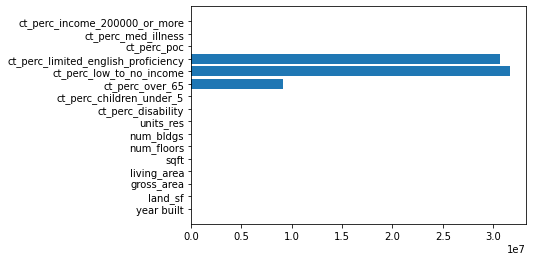

In [207]:
plt.barh(y=list(range(1,16+1)),width=abs(model1.coef_[0]).tolist(),tick_label=setup_1.drop(columns=['Severity','Index_Sum','Frequency_of_Complaints']).columns)
plt.show()
# setup_1.drop(columns=['Severity','Index_Sum','Frequency_of_Complaints']).columns

In [157]:
model1.score(X,y)

0.007076664069837424

In [158]:
y = setup_1['Index_Sum'].to_numpy().reshape(-1, 1)

In [159]:
scaler_y = StandardScaler().fit(y)
y = scaler_y.transform(y)

In [160]:
model2 = LinearRegression().fit(X,y)

In [161]:
model2.coef_

array([[ 1.19500857e-02,  1.87971280e-02,  2.05427739e-01,
        -5.58432772e-01,  2.53116880e-01,  2.07833938e-01,
         4.01103875e+00,  9.42874148e-02, -3.95277448e-02,
        -9.36652935e-02,  3.03798050e+07,  1.05607922e+08,
        -1.02407173e+08,  1.72469647e-02,  2.30124402e-02,
        -2.89201974e-02]])

In [162]:
model2.score(X,y)

0.07019662313862074

In [163]:
y = setup_1['Frequency_of_Complaints'].to_numpy().reshape(-1, 1)

In [164]:
scaler_y = StandardScaler().fit(y)
y = scaler_y.transform(y)

In [165]:
model1 = LinearRegression().fit(X,y)

In [166]:
model1.coef_

array([[ 2.31593535e-02,  1.44996319e-03, -1.21016519e-01,
         4.74364096e-01, -3.37749690e-01, -5.53444890e-02,
        -1.20276240e+00, -4.14474691e-03, -1.36234119e-02,
         4.87822962e-02, -9.10978164e+06, -3.16679159e+07,
         3.07081293e+07, -3.23054018e-02, -5.52868410e-05,
        -1.38910089e-02]])

In [167]:
model1.score(X,y)

0.006110334623749769

### Feature Encoding

In [215]:
X = setup_1.drop(columns=['Severity','Index_Sum','Frequency_of_Complaints']).to_numpy()

In [216]:
y = setup_1['Severity'].to_numpy().reshape(-1, 1)

In [217]:
scaler = StandardScaler().fit(X)
#reassign X_train/ X_test to be the tranformed version of itself
X = scaler.transform(X)

In [218]:
scaler_y = StandardScaler().fit(y)
y = scaler_y.transform(y)

In [219]:
y.shape

(15848, 1)

In [221]:
X.shape

(15848, 16)

In [222]:
feats = setup_1.drop(columns=['Severity','Index_Sum','Frequency_of_Complaints']).columns

In [229]:
feats

Index(['year built', 'land_sf', 'gross_area', 'living_area', 'sqft',
       'num_floors', 'num_bldgs', 'units_res', 'ct_perc_disability',
       'ct_perc_children_under_5', 'ct_perc_over_65',
       'ct_perc_low_to_no_income', 'ct_perc_limited_english_proficiency',
       'ct_perc_poc', 'ct_perc_med_illness', 'ct_perc_income_200000_or_more'],
      dtype='object')

<AxesSubplot:>

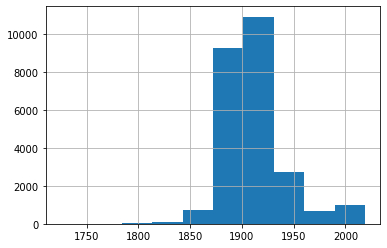

In [169]:
df_byaddress['year built'].hist()

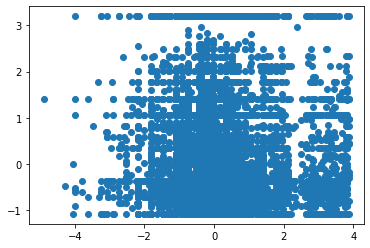

In [228]:
plt.scatter(X[:,0],y)
plt.show()

In [174]:
df_byaddress_v2 = df_byaddress.copy()

In [175]:
df_byaddress_v2['pre_1850'] = df_byaddress['year built'] < 1850.0

In [176]:
df_byaddress_v2['post_1850'] = df_byaddress['year built'] >= 1850.0

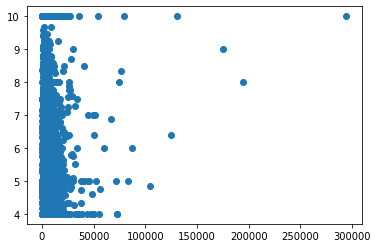

In [209]:
plt.scatter(df_byaddress['land_sf'],df_byaddress['Severity'])
plt.show()

<AxesSubplot:>

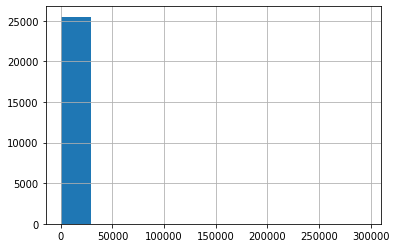

In [178]:
df_byaddress['land_sf'].hist()

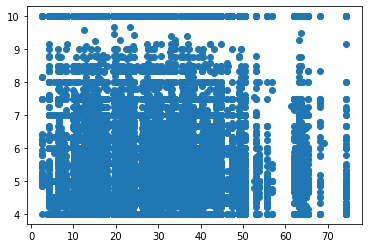

In [231]:
plt.scatter(df_byaddress['ct_perc_low_to_no_income'],df_byaddress['Severity'])
plt.show()

In [232]:
df_byaddress.head()

,year built,land_sf,gross_area,living_area,sqft,num_floors,num_bldgs,units_res,ct_perc_disability,ct_perc_children_under_5,ct_perc_over_65,ct_perc_low_to_no_income,ct_perc_limited_english_proficiency,ct_perc_poc,ct_perc_med_illness,ct_perc_income_200000_or_more,Severity,Index_Sum,Frequency_of_Complaints
address,,,,,,,,,,,,,,,,,,,
"1 Abbotsford St, 02121",1900.0,3577.0,5528.0,3109.0,3109.0,2.0,1.0,2.0,20.738363,22.600321,10.016051,35.345104,45.361156,97.817014,37.262921,1.061571,5.0,10,0.024213
"1 Acorn St, 02108",1829.0,822.0,2939.0,2300.0,2300.0,4.0,1.0,2.0,4.102075,14.190317,12.902456,6.677796,19.580253,9.802051,42.477701,26.284658,8.0,40,0.061538
"1 Adams St, 02129",1857.0,1056.0,4093.0,3843.0,3843.0,4.0,1.0,1.0,6.503690,14.852399,13.376384,9.870849,23.247232,5.350554,42.309963,25.625000,5.0,5,NaN
"1 Akron Pl, 02119",1890.0,1654.0,1911.0,1200.0,1200.0,2.0,1.0,1.0,18.717277,32.722513,10.994764,40.628272,51.623037,98.062827,36.766230,2.694236,5.0,5,NaN
"1 Aldie St, 02134",1890.0,4014.0,4060.0,2623.0,2623.0,2.5,1.0,2.0,7.853982,5.764503,2.704031,41.556047,44.260079,47.246804,36.923550,3.987847,5.0,35,0.025253


In [233]:
df_byaddress.columns

Index(['year built', 'land_sf', 'gross_area', 'living_area', 'sqft',
       'num_floors', 'num_bldgs', 'units_res', 'ct_perc_disability',
       'ct_perc_children_under_5', 'ct_perc_over_65',
       'ct_perc_low_to_no_income', 'ct_perc_limited_english_proficiency',
       'ct_perc_poc', 'ct_perc_med_illness', 'ct_perc_income_200000_or_more',
       'Severity', 'Index_Sum', 'Frequency_of_Complaints'],
      dtype='object')

In [235]:
df_byaddress.to_csv('byaddress_16feats_3targets_v1.csv')

<AxesSubplot:>

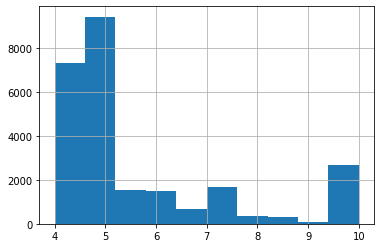

In [236]:
df_byaddress.Severity.hist()